# Summarization Model Evaluation - XSum Dataset

This notebook evaluates different summarization techniques using the **XSum dataset** (extreme summarization).

## Dataset Characteristics
- **XSum**: BBC news articles with extreme single-sentence summaries
- **Article length**: ~430 words (typical)
- **Summary length**: ~20-25 words (single sentence)
- **Summary style**: One concise sentence capturing the essence

## Methods to Evaluate
- **Extractive**: TextRank, LexRank
- **Abstractive**: BART, T5, Pegasus, LED, LongT5

## Metrics
- **ROUGE-1, ROUGE-2, ROUGE-L**: N-gram overlap with reference summaries
- **BERTScore**: Semantic similarity using BERT embeddings
- **METEOR**: Considers synonyms and paraphrasing
- **Compression Ratio**: Summary length vs original length

## Expected Performance
- **Pegasus (XSum)**: Should perform well (trained on XSum)
- **BART**: May struggle (trained on CNN/DailyMail multi-sentence summaries)
- **Extractive methods**: May generate longer summaries than reference
- **LLM methods**: Should adapt well to single-sentence requirement

## 1. Setup and Imports

In [20]:
import sys
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Add project root to path to import from src/
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Import summarization module
from src.summarization import get_summarizer

print(f"Project root: {project_root}")

Project root: /home/amanda/taf/sl-newspaper-bias-analysis


In [ ]:
# API Keys Setup
# IMPORTANT: Never commit API keys to git!
# Option 1: Set environment variables before running notebook
# Option 2: Load from a .env file (add .env to .gitignore)
# Option 3: Use a secrets manager

import os

# Load API keys from environment variables
# Set these in your shell or in a .env file before running:
#   export OPENAI_API_KEY="your-key-here"
#   export GOOGLE_API_KEY="your-key-here"
#   export ANTHROPIC_API_KEY="your-key-here"

# Check if keys are already set, otherwise provide helpful error messages
if "OPENAI_API_KEY" not in os.environ:
    print("⚠️  Warning: OPENAI_API_KEY not set. GPT summarization will fail.")
    print("   Set it with: export OPENAI_API_KEY='your-key-here'")

if "GOOGLE_API_KEY" not in os.environ:
    print("⚠️  Warning: GOOGLE_API_KEY not set. Gemini summarization will fail.")
    print("   Set it with: export GOOGLE_API_KEY='your-key-here'")

if "ANTHROPIC_API_KEY" not in os.environ:
    print("⚠️  Warning: ANTHROPIC_API_KEY not set. Claude summarization will fail.")
    print("   Set it with: export ANTHROPIC_API_KEY='your-key-here'")

print("✓ API key setup complete")

## 1.1. Setup Summary Caching

In [ ]:
import json
import hashlib
from pathlib import Path
from datetime import datetime

# Cache configuration
CACHE_DIR = Path("cache/summarization/xsum")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
USE_CACHE = True  # Set to False to regenerate all summaries

def get_article_hash(article_text: str) -> str:
    """Generate deterministic hash for article text."""
    return hashlib.sha256(article_text.encode('utf-8')).hexdigest()

def get_cache_path(method: str, summary_length: str) -> Path:
    """Get cache file path for method and length."""
    return CACHE_DIR / f"{method}_{summary_length}.json"

def load_cache(method: str, summary_length: str) -> dict:
    """Load cached summaries if available."""
    cache_path = get_cache_path(method, summary_length)
    if not USE_CACHE or not cache_path.exists():
        return None
    
    with open(cache_path, 'r') as f:
        return json.load(f)

def save_cache(method: str, summary_length: str, summaries: dict,
               sample_size: int, random_seed: int):
    """Save summaries to cache with metadata."""
    cache_path = get_cache_path(method, summary_length)
    
    cache_data = {
        "metadata": {
            "method": method,
            "summary_length": summary_length,
            "dataset": "xsum",
            "dataset_version": "1.2.0",
            "sample_size": sample_size,
            "random_seed": random_seed,
            "created_at": datetime.now().isoformat(),
            "last_updated": datetime.now().isoformat()
        },
        "summaries": summaries
    }
    
    with open(cache_path, 'w') as f:
        json.dump(cache_data, f, indent=2)

def get_summaries_from_cache(method: str, summary_length: str,
                             articles: list) -> tuple:
    """
    Get summaries from cache if available and complete.
    
    Returns:
        Tuple of (summaries list, is_from_cache bool)
        summaries is None if cache is incomplete
    """
    cache_data = load_cache(method, summary_length)
    if cache_data is None:
        return None, False
    
    # Generate article hashes
    article_hashes = [get_article_hash(article) for article in articles]
    
    # Check if all articles are in cache
    cached_summaries = cache_data.get("summaries", {})
    if not all(h in cached_summaries for h in article_hashes):
        print(f"  Cache incomplete for {method}, will regenerate missing summaries")
        return None, False
    
    # Return summaries in correct order
    summaries = [cached_summaries[h] for h in article_hashes]
    print(f"  ✓ Loaded {len(summaries)} summaries from cache")
    return summaries, True

print("Cache functions loaded. Cache directory:", CACHE_DIR)
print(f"Cache mode: {'ENABLED' if USE_CACHE else 'DISABLED'}")

Cache functions loaded. Cache directory: cache/xsum
Cache mode: ENABLED


In [23]:
# Install evaluation dependencies if needed
# Uncomment and run if packages are missing

# !pip install datasets rouge-score bert-score nltk

In [24]:
# Import evaluation libraries
from datasets import load_dataset
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import nltk

# Download NLTK data for METEOR
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("All evaluation libraries loaded successfully!")

All evaluation libraries loaded successfully!


## 2. Load XSum Dataset

In [25]:
# Load XSum dataset
# XSum features extreme summarization - single sentence summaries
print("Loading XSum dataset...")
dataset = load_dataset("xsum", split="test")

print(f"Total test samples: {len(dataset)}")
print(f"\nDataset features: {dataset.features}")

Loading XSum dataset...
Total test samples: 11334

Dataset features: {'document': Value('string'), 'summary': Value('string'), 'id': Value('string')}


In [26]:
# Sample a subset for evaluation (full dataset takes too long)
# Adjust SAMPLE_SIZE based on your compute resources
SAMPLE_SIZE = 100  # Use 100 samples for reasonable evaluation time
RANDOM_SEED = 42

# Shuffle and select samples
eval_dataset = dataset.shuffle(seed=RANDOM_SEED).select(range(SAMPLE_SIZE))

print(f"Evaluation sample size: {len(eval_dataset)}")

# Preview a sample
sample = eval_dataset[0]
print(f"\n--- Sample Article (first 500 chars) ---")
print(sample['document'][:500])
print(f"\n--- Reference Summary ---")
print(sample['summary'])

Evaluation sample size: 100

--- Sample Article (first 500 chars) ---
Sarah Johnson was one of 21 women heading to Liverpool when their minibus was hit by a lorry on the M62.
Her friend Bethany Jones, 18, was killed while Ms Johnson and several others were badly hurt.
Minibus driver James Johnson was jailed for more than six years for causing Bethany's death, in April 2013.
Ms Johnson, who broke her shoulder, back and pelvis, said the help she received from a charity while in hospital led her to want to support others.
Speaking publicly for the first time about th

--- Reference Summary ---
A woman who was seriously hurt in a fatal hen party motorway crash is now helping other major trauma victims rebuild their lives.


In [27]:
# Prepare data as lists for easier processing
# XSum uses 'document' and 'summary' instead of 'article' and 'highlights'
articles = eval_dataset['document']
references = eval_dataset['summary']

# Basic statistics
article_lengths = [len(a.split()) for a in articles]
reference_lengths = [len(r.split()) for r in references]

print(f"Article word count - Mean: {np.mean(article_lengths):.0f}, Median: {np.median(article_lengths):.0f}")
print(f"Reference word count - Mean: {np.mean(reference_lengths):.0f}, Median: {np.median(reference_lengths):.0f}")

Article word count - Mean: 361, Median: 280
Reference word count - Mean: 21, Median: 20


## 3. Define Evaluation Functions

In [28]:
def validate_summary_completeness(predictions: list) -> dict:
    """
    Check for incomplete summaries (mid-sentence truncation).

    Returns dict with validation statistics.
    """
    def is_complete(text):
        if not text or not text.strip():
            return False
        text = text.strip()
        # Check if ends with sentence-ending punctuation
        if text.endswith(('.', '!', '?')):
            return True
        # Check if ends with quote and has punctuation before it
        if text.endswith(("'", '"', "'", '"')) and len(text) > 1:
            return text[-2] in '.!?'
        return False

    complete_count = sum(1 for p in predictions if p and is_complete(p))
    incomplete_count = sum(1 for p in predictions if p and not is_complete(p))
    empty_count = sum(1 for p in predictions if not p or not p.strip())

    return {
        'complete': complete_count,
        'incomplete': incomplete_count,
        'empty': empty_count,
        'completion_rate': complete_count / len(predictions) if predictions else 0
    }

def calculate_rouge_scores(predictions: list, references: list) -> dict:
    """
    Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores.
    
    Returns dict with precision, recall, and F1 for each metric.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for pred, ref in zip(predictions, references):
        if not pred or not pred.strip():
            for key in scores:
                scores[key].append({'precision': 0, 'recall': 0, 'fmeasure': 0})
            continue
            
        result = scorer.score(ref, pred)
        for key in scores:
            scores[key].append({
                'precision': result[key].precision,
                'recall': result[key].recall,
                'fmeasure': result[key].fmeasure
            })
    
    # Aggregate scores
    aggregated = {}
    for metric in scores:
        aggregated[f'{metric}_precision'] = np.mean([s['precision'] for s in scores[metric]])
        aggregated[f'{metric}_recall'] = np.mean([s['recall'] for s in scores[metric]])
        aggregated[f'{metric}_f1'] = np.mean([s['fmeasure'] for s in scores[metric]])
    
    return aggregated


def calculate_bert_scores(predictions: list, references: list) -> dict:
    """
    Calculate BERTScore for semantic similarity.
    
    Returns dict with precision, recall, and F1.
    """
    # Filter out empty predictions
    valid_pairs = [(p, r) for p, r in zip(predictions, references) if p and p.strip()]
    
    if not valid_pairs:
        return {'bertscore_precision': 0, 'bertscore_recall': 0, 'bertscore_f1': 0}
    
    valid_preds, valid_refs = zip(*valid_pairs)
    
    P, R, F1 = bert_score(list(valid_preds), list(valid_refs), lang='en', verbose=False)
    
    return {
        'bertscore_precision': P.mean().item(),
        'bertscore_recall': R.mean().item(),
        'bertscore_f1': F1.mean().item()
    }


def calculate_meteor_scores(predictions: list, references: list) -> dict:
    """
    Calculate METEOR score.
    
    Returns dict with mean METEOR score.
    """
    scores = []
    
    for pred, ref in zip(predictions, references):
        if not pred or not pred.strip():
            scores.append(0)
            continue
        
        # Tokenize for METEOR
        pred_tokens = word_tokenize(pred.lower())
        ref_tokens = word_tokenize(ref.lower())
        
        score = meteor_score([ref_tokens], pred_tokens)
        scores.append(score)
    
    return {'meteor': np.mean(scores)}


def calculate_compression_ratio(predictions: list, articles: list) -> dict:
    """
    Calculate compression ratio (summary length / article length).
    """
    ratios = []
    
    for pred, article in zip(predictions, articles):
        if not pred or not pred.strip():
            ratios.append(0)
            continue
        
        pred_words = len(pred.split())
        article_words = len(article.split())
        
        ratio = pred_words / article_words if article_words > 0 else 0
        ratios.append(ratio)
    
    return {
        'compression_ratio_mean': np.mean(ratios),
        'compression_ratio_std': np.std(ratios)
    }

In [29]:
def evaluate_summarizer(method: str, articles: list, references: list, 
                        summary_length: str = "medium") -> dict:
    """
    Run a summarizer on all articles and calculate all metrics.
    
    Checks cache first to avoid regenerating summaries.
    
    Args:
        method: Summarization method (textrank, lexrank, bart, t5, etc.)
        articles: List of article texts
        references: List of reference summaries
        summary_length: Target summary length (short, medium, long)
    
    Returns:
        Dictionary with all metrics and timing info
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {method.upper()}")
    print(f"{'='*60}")
    
    # Check cache first
    cached_summaries, is_cached = get_summaries_from_cache(method, summary_length, articles)
    
    if cached_summaries is not None:
        predictions = cached_summaries
        processing_times = [0.0] * len(articles)  # No processing time for cached results
        failed_count = sum(1 for p in predictions if not p or not p.strip())
        print(f"Using cached summaries. Failed: {failed_count}/{len(articles)}")
    else:
        # Generate summaries (existing code)
        print("Generating summaries...")
        config = {
            "method": method,
            "summary_length": summary_length,
            "chunk_long_articles": True
        }
        
        try:
            summarizer = get_summarizer(config)
        except Exception as e:
            print(f"Failed to initialize {method}: {e}")
            return None, None
        
        predictions = []
        processing_times = []
        failed_count = 0
        
        for article in tqdm(articles, desc=f"Summarizing with {method}"):
            start_time = time.time()
            try:
                summary = summarizer.summarize(article)
                predictions.append(summary if summary else "")
                if not summary:
                    failed_count += 1
            except Exception as e:
                print(f"Error: {e}")
                predictions.append("")
                failed_count += 1
            
            processing_times.append(time.time() - start_time)
        
        print(f"\nSummarization complete. Failed: {failed_count}/{len(articles)}")
        
        # Save to cache
        article_hashes = [get_article_hash(article) for article in articles]
        summaries_dict = dict(zip(article_hashes, predictions))
        save_cache(method, summary_length, summaries_dict, len(articles), RANDOM_SEED)
        print(f"  ✓ Saved summaries to cache")
    
    # Validate output quality
    validation = validate_summary_completeness(predictions)
    print(f"\nOutput Quality:")
    print(f"  Complete summaries: {validation['complete']}/{len(predictions)} ({validation['completion_rate']:.1%})")
    print(f"  Incomplete summaries: {validation['incomplete']}")
    print(f"  Empty summaries: {validation['empty']}")
    if validation['incomplete'] > 0:
        print(f"  ⚠️  Warning: {validation['incomplete']} summaries are truncated mid-sentence!")
    
    # Calculate all metrics
    print("\nCalculating ROUGE scores...")
    rouge_scores = calculate_rouge_scores(predictions, references)
    
    print("Calculating BERTScore...")
    bert_scores = calculate_bert_scores(predictions, references)
    
    print("Calculating METEOR score...")
    meteor_scores = calculate_meteor_scores(predictions, references)
    
    print("Calculating compression ratio...")
    compression = calculate_compression_ratio(predictions, articles)
    
    # Combine all results
    results = {
        'method': method,
        'num_samples': len(articles),
        'failed_count': failed_count,
        'complete_count': validation['complete'],
        'incomplete_count': validation['incomplete'],
        'completion_rate': validation['completion_rate'],
        'avg_time_seconds': np.mean(processing_times),
        'total_time_seconds': sum(processing_times),
        **rouge_scores,
        **bert_scores,
        **meteor_scores,
        **compression
    }
    
    # Print summary
    print(f"\n--- Results for {method.upper()} ---")
    print(f"ROUGE-1 F1: {results['rouge1_f1']:.4f}")
    print(f"ROUGE-2 F1: {results['rouge2_f1']:.4f}")
    print(f"ROUGE-L F1: {results['rougeL_f1']:.4f}")
    print(f"BERTScore F1: {results['bertscore_f1']:.4f}")
    print(f"METEOR: {results['meteor']:.4f}")
    print(f"Avg Time: {results['avg_time_seconds']:.2f}s {'(cached)' if is_cached else ''}")
    
    return results, predictions

## 4. Run Evaluation on All Methods

In [30]:
# Define methods to evaluate
# Note: After fixing the bug, transformer models now generate summaries
# using natural stopping (EOS tokens) rather than hard token limits.
# Summary lengths may vary more than before, but outputs will be complete.

METHODS_TO_EVALUATE = [
    # Extractive methods (fast, fixed length)
    "textrank",
    "lexrank",

    # Abstractive transformer methods (natural length, complete sentences)
    "bart",
    "pegasus",
    "t5",
    "led",
    "longt5",
    "bigbird-pegasus",
    
    # LLM-based methods (requires API keys - uncomment to use)
    # "claude",  # Requires ANTHROPIC_API_KEY
    "gpt",     # Requires OPENAI_API_KEY
    "gemini",  # Requires GOOGLE_API_KEY
]

print(f"Methods to evaluate: {METHODS_TO_EVALUATE}")

Methods to evaluate: ['textrank', 'lexrank', 'bart', 'pegasus', 't5', 'led', 'longt5', 'bigbird-pegasus', 'gpt', 'gemini']


In [31]:
# Run evaluation for all methods
all_results = []
all_predictions = {}

for method in METHODS_TO_EVALUATE:
    result, predictions = evaluate_summarizer(
        method=method,
        articles=articles,
        references=references,
        summary_length="short"
    )
    
    if result:
        all_results.append(result)
        all_predictions[method] = predictions

print(f"\n\n{'='*60}")
print("EVALUATION COMPLETE!")
print(f"{'='*60}")


Evaluating: TEXTRANK
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 100/100 (100.0%)
  Incomplete summaries: 0
  Empty summaries: 0

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for TEXTRANK ---
ROUGE-1 F1: 0.1725
ROUGE-2 F1: 0.0299
ROUGE-L F1: 0.1117
BERTScore F1: 0.8504
METEOR: 0.2102
Avg Time: 0.00s (cached)

Evaluating: LEXRANK
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 100/100 (100.0%)
  Incomplete summaries: 0
  Empty summaries: 0

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for LEXRANK ---
ROUGE-1 F1: 0.1897
ROUGE-2 F1: 0.0326
ROUGE-L F1: 0.1223
BERTScore F1: 0.8542
METEOR: 0.2193
Avg Time: 0.00s (cached)

Evaluating: BART
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 91/100 (91.0%)
  Incomplete summaries: 9
  Empty summaries: 0
  ⚠️  Warning: 9 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for BART ---
ROUGE-1 F1: 0.2099
ROUGE-2 F1: 0.0334
ROUGE-L F1: 0.1337
BERTScore F1: 0.8576
METEOR: 0.2181
Avg Time: 0.00s (cached)

Evaluating: PEGASUS
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 99/100 (99.0%)
  Incomplete summaries: 1
  Empty summaries: 0
  ⚠️  Warning: 1 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for PEGASUS ---
ROUGE-1 F1: 0.4174
ROUGE-2 F1: 0.2002
ROUGE-L F1: 0.3496
BERTScore F1: 0.9106
METEOR: 0.3851
Avg Time: 0.00s (cached)

Evaluating: T5
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 95/100 (95.0%)
  Incomplete summaries: 5
  Empty summaries: 0
  ⚠️  Warning: 5 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for T5 ---
ROUGE-1 F1: 0.1945
ROUGE-2 F1: 0.0263
ROUGE-L F1: 0.1311
BERTScore F1: 0.8469
METEOR: 0.1928
Avg Time: 0.00s (cached)

Evaluating: LED
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 31/100 (31.0%)
  Incomplete summaries: 69
  Empty summaries: 0
  ⚠️  Warning: 69 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for LED ---
ROUGE-1 F1: 0.1251
ROUGE-2 F1: 0.0250
ROUGE-L F1: 0.0827
BERTScore F1: 0.8420
METEOR: 0.2096
Avg Time: 0.00s (cached)

Evaluating: LONGT5
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 99/100 (99.0%)
  Incomplete summaries: 1
  Empty summaries: 0
  ⚠️  Warning: 1 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for LONGT5 ---
ROUGE-1 F1: 0.1859
ROUGE-2 F1: 0.0290
ROUGE-L F1: 0.1308
BERTScore F1: 0.8537
METEOR: 0.1730
Avg Time: 0.00s (cached)

Evaluating: BIGBIRD-PEGASUS
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 23/100 (23.0%)
  Incomplete summaries: 77
  Empty summaries: 0
  ⚠️  Warning: 77 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for BIGBIRD-PEGASUS ---
ROUGE-1 F1: 0.0675
ROUGE-2 F1: 0.0082
ROUGE-L F1: 0.0551
BERTScore F1: 0.7784
METEOR: 0.0804
Avg Time: 0.00s (cached)

Evaluating: GPT
Generating summaries...


Summarizing with gpt:   0%|          | 0/100 [00:00<?, ?it/s]


Summarization complete. Failed: 0/100
  ✓ Saved summaries to cache

Output Quality:
  Complete summaries: 100/100 (100.0%)
  Incomplete summaries: 0
  Empty summaries: 0

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for GPT ---
ROUGE-1 F1: 0.2073
ROUGE-2 F1: 0.0455
ROUGE-L F1: 0.1369
BERTScore F1: 0.8623
METEOR: 0.2390
Avg Time: 2.17s 

Evaluating: GEMINI
Generating summaries...


Summarizing with gemini:   0%|          | 0/100 [00:00<?, ?it/s]


Summarization complete. Failed: 0/100
  ✓ Saved summaries to cache

Output Quality:
  Complete summaries: 100/100 (100.0%)
  Incomplete summaries: 0
  Empty summaries: 0

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for GEMINI ---
ROUGE-1 F1: 0.2029
ROUGE-2 F1: 0.0410
ROUGE-L F1: 0.1363
BERTScore F1: 0.8593
METEOR: 0.2226
Avg Time: 1.47s 


EVALUATION COMPLETE!


## 5. Results Analysis

In [32]:
results_df = pd.DataFrame(all_results)

display_columns = [
    'method', 
    'rouge1_f1', 'rouge2_f1', 'rougeL_f1',
    'bertscore_f1', 'meteor',
    'compression_ratio_mean', 'avg_time_seconds'
]

display_df = results_df[display_columns].copy()
display_df.columns = [
    'Method', 
    'ROUGE-1', 'ROUGE-2', 'ROUGE-L',
    'BERTScore', 'METEOR',
    'Compression', 'Avg Time (s)'
]

for col in display_df.columns[1:]:
    if col != 'Avg Time (s)':
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    else:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}")

print("\n" + "="*80)
print("SUMMARIZATION EVALUATION RESULTS")
print("="*80)
display(display_df)


SUMMARIZATION EVALUATION RESULTS


,Method,ROUGE-1,ROUGE-2,ROUGE-L,BERTScore,METEOR,Compression,Avg Time (s)
0,textrank,0.1725,0.0299,0.1117,0.8504,0.2102,0.3420,0.00
1,lexrank,0.1897,0.0326,0.1223,0.8542,0.2193,0.2851,0.00
2,bart,0.2099,0.0334,0.1337,0.8576,0.2181,0.2463,0.00
3,pegasus,0.4174,0.2002,0.3496,0.9106,0.3851,0.0955,0.00
4,t5,0.1945,0.0263,0.1311,0.8469,0.1928,0.2139,0.00
5,led,0.1251,0.0250,0.0827,0.8420,0.2096,0.6810,0.00
6,longt5,0.1859,0.0290,0.1308,0.8537,0.1730,0.1374,0.00
7,bigbird-pegasus,0.0675,0.0082,0.0551,0.7784,0.0804,0.7900,0.00
8,gpt,0.2073,0.0455,0.1369,0.8623,0.2390,0.2986,2.17
9,gemini,0.2029,0.0410,0.1363,0.8593,0.2226,0.2762,1.47


In [33]:
results_df.to_csv('summarization_evaluation_results.csv', index=False)
print("Results saved to summarization_evaluation_results.csv")

Results saved to summarization_evaluation_results.csv


## 6. Visualize Results

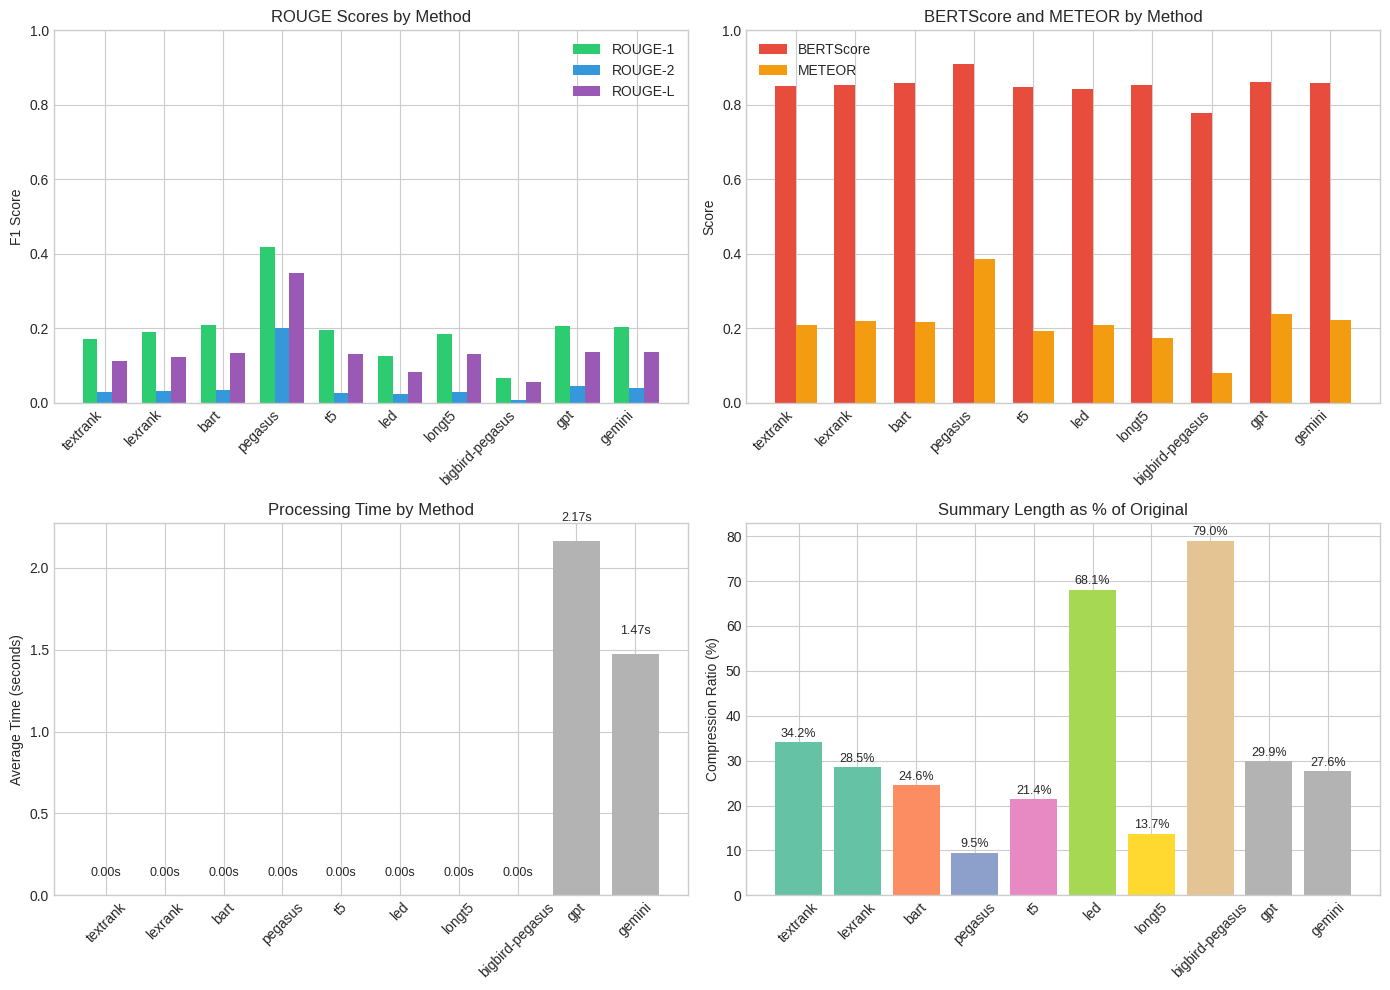


Plots saved to summarization_evaluation_plots.png


In [34]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods = results_df['method'].tolist()
colors = plt.cm.Set2(np.linspace(0, 1, len(methods)))

# Plot 1: ROUGE Scores Comparison
ax1 = axes[0, 0]
x = np.arange(len(methods))
width = 0.25

ax1.bar(x - width, results_df['rouge1_f1'], width, label='ROUGE-1', color='#2ecc71')
ax1.bar(x, results_df['rouge2_f1'], width, label='ROUGE-2', color='#3498db')
ax1.bar(x + width, results_df['rougeL_f1'], width, label='ROUGE-L', color='#9b59b6')

ax1.set_ylabel('F1 Score')
ax1.set_title('ROUGE Scores by Method')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1)

# Plot 2: BERTScore and METEOR
ax2 = axes[0, 1]
x = np.arange(len(methods))
width = 0.35

ax2.bar(x - width/2, results_df['bertscore_f1'], width, label='BERTScore', color='#e74c3c')
ax2.bar(x + width/2, results_df['meteor'], width, label='METEOR', color='#f39c12')

ax2.set_ylabel('Score')
ax2.set_title('BERTScore and METEOR by Method')
ax2.set_xticks(x)
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.legend()
ax2.set_ylim(0, 1)

# Plot 3: Processing Time
ax3 = axes[1, 0]
bars = ax3.bar(methods, results_df['avg_time_seconds'], color=colors)
ax3.set_ylabel('Average Time (seconds)')
ax3.set_title('Processing Time by Method')
ax3.tick_params(axis='x', rotation=45)

for bar, val in zip(bars, results_df['avg_time_seconds']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.2f}s', ha='center', va='bottom', fontsize=9)

# Plot 4: Compression Ratio
ax4 = axes[1, 1]
bars = ax4.bar(methods, results_df['compression_ratio_mean'] * 100, color=colors)
ax4.set_ylabel('Compression Ratio (%)')
ax4.set_title('Summary Length as % of Original')
ax4.tick_params(axis='x', rotation=45)

for bar, val in zip(bars, results_df['compression_ratio_mean'] * 100):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('summarization_evaluation_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlots saved to summarization_evaluation_plots.png")

## 7. Detailed Comparison: Sample Outputs

In [35]:
sample_idx = 0

print(f"\n{'='*80}")
print(f"SAMPLE ARTICLE #{sample_idx + 1}")
print(f"{'='*80}")
print(f"\n{articles[sample_idx][:1000]}...")

print(f"\n{'='*80}")
print("REFERENCE SUMMARY (Ground Truth)")
print(f"{'='*80}")
print(f"\n{references[sample_idx]}")

print(f"\n{'='*80}")
print("GENERATED SUMMARIES")
print(f"{'='*80}")

for method, preds in all_predictions.items():
    print(f"\n--- {method.upper()} ---")
    print(preds[sample_idx] if preds[sample_idx] else "[Empty summary]")


SAMPLE ARTICLE #1

Sarah Johnson was one of 21 women heading to Liverpool when their minibus was hit by a lorry on the M62.
Her friend Bethany Jones, 18, was killed while Ms Johnson and several others were badly hurt.
Minibus driver James Johnson was jailed for more than six years for causing Bethany's death, in April 2013.
Ms Johnson, who broke her shoulder, back and pelvis, said the help she received from a charity while in hospital led her to want to support others.
Speaking publicly for the first time about the crash, Ms Johnson described how everyone was "excited and giddy" for the hen party.
"To me the impact was just a massive explosion," she said.  "I thought the bus had blown up.
"I remember the bus dropping on its side. The next thing, I woke up on the roadside so I'd actually come out of the window."
Ms Johnson was taken to Leeds General Infirmary where she, along with Bethany's sister Amy Firth, underwent major surgery and spent time in intensive care.
Whilst she was there

## 8. Statistical Summary and Recommendations

In [36]:
print("\n" + "="*80)
print("METHOD RANKINGS")
print("="*80)

metrics_to_rank = ['rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'bertscore_f1', 'meteor']

for metric in metrics_to_rank:
    sorted_df = results_df.sort_values(metric, ascending=False)
    print(f"\nTop methods by {metric}:")
    for i, (_, row) in enumerate(sorted_df.iterrows(), 1):
        print(f"  {i}. {row['method']}: {row[metric]:.4f}")

# Overall score (average of normalized metrics)
print(f"\n{'='*80}")
print("OVERALL RANKING (Average of all metrics)")
print(f"{'='*80}")

# Normalize each metric to 0-1 scale and compute average
normalized_df = results_df.copy()
for metric in metrics_to_rank:
    min_val = normalized_df[metric].min()
    max_val = normalized_df[metric].max()
    if max_val > min_val:
        normalized_df[f'{metric}_norm'] = (normalized_df[metric] - min_val) / (max_val - min_val)
    else:
        normalized_df[f'{metric}_norm'] = 1.0

norm_cols = [f'{m}_norm' for m in metrics_to_rank]
normalized_df['overall_score'] = normalized_df[norm_cols].mean(axis=1)

final_ranking = normalized_df.sort_values('overall_score', ascending=False)[['method', 'overall_score']]
for i, (_, row) in enumerate(final_ranking.iterrows(), 1):
    print(f"  {i}. {row['method']}: {row['overall_score']:.4f}")


METHOD RANKINGS

Top methods by rouge1_f1:
  1. pegasus: 0.4174
  2. bart: 0.2099
  3. gpt: 0.2073
  4. gemini: 0.2029
  5. t5: 0.1945
  6. lexrank: 0.1897
  7. longt5: 0.1859
  8. textrank: 0.1725
  9. led: 0.1251
  10. bigbird-pegasus: 0.0675

Top methods by rouge2_f1:
  1. pegasus: 0.2002
  2. gpt: 0.0455
  3. gemini: 0.0410
  4. bart: 0.0334
  5. lexrank: 0.0326
  6. textrank: 0.0299
  7. longt5: 0.0290
  8. t5: 0.0263
  9. led: 0.0250
  10. bigbird-pegasus: 0.0082

Top methods by rougeL_f1:
  1. pegasus: 0.3496
  2. gpt: 0.1369
  3. gemini: 0.1363
  4. bart: 0.1337
  5. t5: 0.1311
  6. longt5: 0.1308
  7. lexrank: 0.1223
  8. textrank: 0.1117
  9. led: 0.0827
  10. bigbird-pegasus: 0.0551

Top methods by bertscore_f1:
  1. pegasus: 0.9106
  2. gpt: 0.8623
  3. gemini: 0.8593
  4. bart: 0.8576
  5. lexrank: 0.8542
  6. longt5: 0.8537
  7. textrank: 0.8504
  8. t5: 0.8469
  9. led: 0.8420
  10. bigbird-pegasus: 0.7784

Top methods by meteor:
  1. pegasus: 0.3851
  2. gpt: 0.2390
  

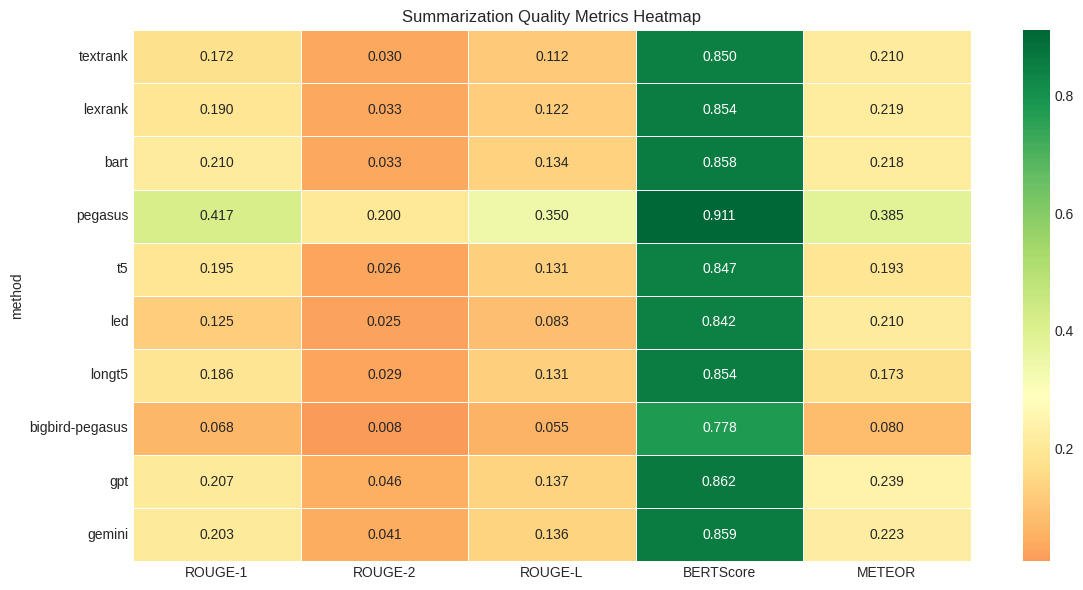


Heatmap saved to summarization_heatmap.png


In [37]:
plt.figure(figsize=(12, 6))

heatmap_data = results_df.set_index('method')[metrics_to_rank]
heatmap_data.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore', 'METEOR']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=heatmap_data.values.mean(), linewidths=0.5)
plt.title('Summarization Quality Metrics Heatmap')
plt.tight_layout()
plt.savefig('summarization_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHeatmap saved to summarization_heatmap.png")

## 9. Cache Management Utilities

In [38]:
# Cache Management Utilities

def clear_cache(method: str = None):
    """Clear cache for specific method or all methods."""
    if method:
        for cache_file in CACHE_DIR.glob(f"{method}_*.json"):
            cache_file.unlink()
            print(f"Deleted: {cache_file.name}")
    else:
        for cache_file in CACHE_DIR.glob("*.json"):
            cache_file.unlink()
            print(f"Deleted: {cache_file.name}")

def list_cache_files():
    """List all cache files with metadata."""
    cache_files = sorted(CACHE_DIR.glob("*.json"))
    if not cache_files:
        print("No cache files found")
        return
    
    print(f"\nFound {len(cache_files)} cache files:")
    print("-" * 80)
    for cache_file in cache_files:
        with open(cache_file) as f:
            data = json.load(f)
        meta = data.get("metadata", {})
        num_summaries = len(data.get("summaries", {}))
        print(f"{cache_file.name}")
        print(f"  Created: {meta.get('created_at', 'unknown')}")
        print(f"  Summaries: {num_summaries}")
        print(f"  Sample size: {meta.get('sample_size', 'unknown')}")
        print()

# List current cache files
list_cache_files()

# Example usage:
# clear_cache("bart")  # Clear BART cache only
# clear_cache()  # Clear all caches


Found 10 cache files:
--------------------------------------------------------------------------------
bart_short.json
  Created: 2026-02-02T10:08:47.715147
  Summaries: 100
  Sample size: 100

bigbird-pegasus_short.json
  Created: 2026-02-02T11:24:48.473507
  Summaries: 100
  Sample size: 100

gemini_short.json
  Created: 2026-02-02T11:39:36.262609
  Summaries: 100
  Sample size: 100

gpt_short.json
  Created: 2026-02-02T11:37:05.334657
  Summaries: 100
  Sample size: 100

led_short.json
  Created: 2026-02-02T10:37:47.647026
  Summaries: 100
  Sample size: 100

lexrank_short.json
  Created: 2026-02-02T09:59:36.274301
  Summaries: 100
  Sample size: 100

longt5_short.json
  Created: 2026-02-02T10:47:29.947559
  Summaries: 100
  Sample size: 100

pegasus_short.json
  Created: 2026-02-02T10:15:41.862620
  Summaries: 100
  Sample size: 100

t5_short.json
  Created: 2026-02-02T10:23:48.223083
  Summaries: 100
  Sample size: 100

textrank_short.json
  Created: 2026-02-02T09:59:27.541764
  